Deep Learning

Using medical imaging dataset MedNIST, which comprises aroung 60,000 images, with about 10,000 images for each six tyoes: check radiographs, head CTs, chest CTs, abdomen CTs, breast MRIs, and brain MRIs. In this project, 1,000 images were selected randomly for each type to build the training and testing datasets with the goal of building an AI model that can accurately classify images in the six categories previous mentioned.

# Part A: Load Data

## Importing necessary packages

In [ ]:
import os
import numpy as np
import pandas as pd

import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random

#import tensorflow as tf
#from tensorflow import keras
#from PIL import Image

## PyTorch ##
import torch
# import torch.nn as nn you can make your code more concise
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms

#added packages
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch import flatten

## Loading the Data

In [ ]:
# Import dataset from kaggle
from google.colab import files

In [ ]:
#upload the 'kaggle.json' file downloaded on kaggle
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"belindalafaille","key":"ea35a5575b76e087acb541659bba3402"}'}

In [ ]:
!pip install -q kaggle #Install the python package that allow the connection with kaggle
!mkdir -p ~/.kaggle #This is required by kaggle
!cp kaggle.json ~/.kaggle/ #This is required by kaggle
!chmod 600 /root/.kaggle/kaggle.json
!pwd

/content


In [ ]:
# Download the medNIST dataset zipfile
!kaggle datasets download -d andrewmvd/medical-mnist

# Unzip the downloaded file
!unzip -q medical-mnist.zip -d 'medical-mnist'

medical-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
replace medical-mnist/AbdomenCT/000000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#load data
image_dir = 'medical-mnist/'

## Converting to JPEG

In [ ]:
# Define Transforms to convert JPEG to tensor
image_transforms = transforms.Compose([
        transforms.ToTensor()
    ])


In [ ]:
# Initialize Dataset
img_dataset = datasets.ImageFolder(
                          root = image_dir,
                          transform = image_transforms
                       )
img_dataset


In [ ]:
#test
size= len(img_dataset)
print(size)

58954


In [ ]:
# Class <=> ID Mapping
img_dataset.class_to_idx

{'AbdomenCT': 0,
 'BreastMRI': 1,
 'CXR': 2,
 'ChestCT': 3,
 'Hand': 4,
 'HeadCT': 5}

In [ ]:
idx2class = {v: k for k, v in img_dataset.class_to_idx.items()}
idx2class

{0: 'AbdomenCT',
 1: 'BreastMRI',
 2: 'CXR',
 3: 'ChestCT',
 4: 'Hand',
 5: 'HeadCT'}

## Displaying 10 random images

In [ ]:
rand_idx = np.random.randint(6000, size=(10))
rand_idx

array([2965, 1660, 3224, 5294, 1768, 2494, 5798, 3873, 3811,  136])

In [ ]:
sampler_10 = SubsetRandomSampler(rand_idx)
loader_10 = DataLoader(dataset=img_dataset, shuffle=False, batch_size=1, sampler=sampler_10)

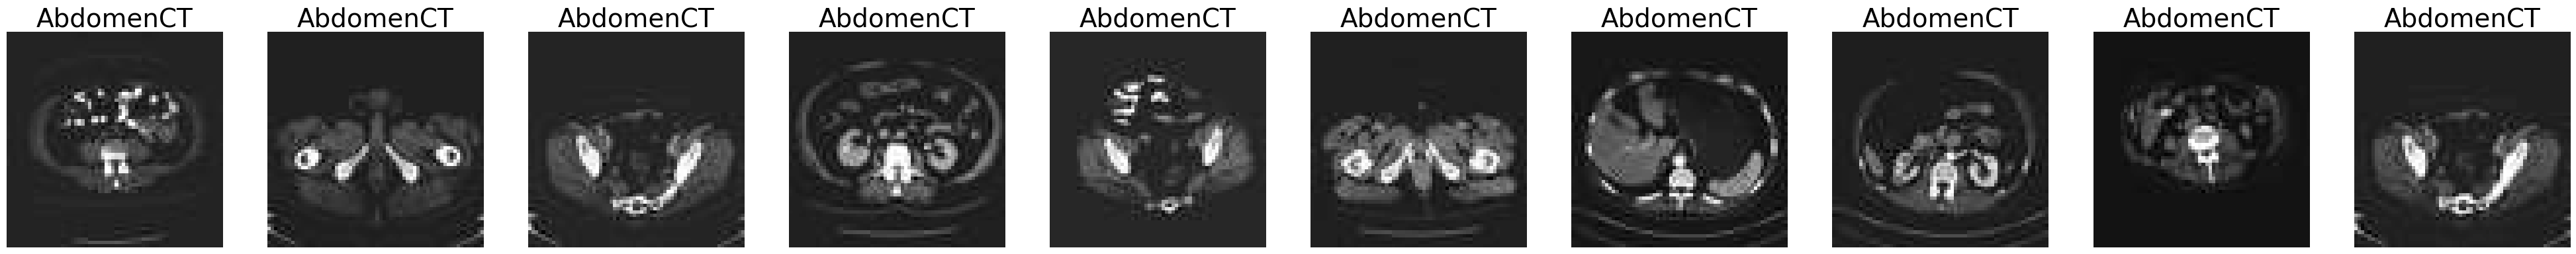

In [ ]:
plt.figure(figsize=(50,50))
for i, batch in enumerate(loader_10, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    plt.imshow(image[0][0], cmap='gray')
    plt.axis('off')
    plt.title(img_dataset.classes[label.item()], fontsize=28)
plt.show()

## Randomly Splitting the Dataset

In [ ]:
# Split sets

train_split_ratio= int(size*0.5)
test_split_ratio= int(size*0.5)

#print(train_split_ratio)

train_dataset, val_dataset = random_split(img_dataset, (train_split_ratio, test_split_ratio))
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=1)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 29477
Length of the val_loader: 29477


# Part B: Build the Neural Network

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=6):
    #parent constructor
    super(CNN, self).__init__()
    # Setting up first layer set: CONV, RELU, POOL
    self.conv_1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(6, 6))
    self.relu_1 = nn.ReLU()
    self.maxpool_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # Setting up second layer set: CONV, RELU, POOL
    self.conv_2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5, 5))
    self.relu_2 = nn.ReLU()
    self.maxpool_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # Define the layers connection
    self.fc_1 = nn.Linear(in_features=2028, out_features=500)
    self.relu_3 = nn.ReLU()
    self.fc_2 = nn.Linear(in_features=500, out_features=100)
    self.relu_4 = nn.ReLU()
    # Setting up softmax classifier
    self.fc_3 = nn.Linear(in_features=100, out_features=num_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # Assign the first set of CONV, RELU, POOL layers input
    x = self.conv_1(x)
    x = self.relu_1(x)
    x = self.maxpool_1(x)
    # Assign the output from the previous layer through the second set of CONV, RELU, POOL layers
    x = self.conv_2(x)
    x = self.relu_2(x)
    x = self.maxpool_2(x)
    # Flatten the output from first layer
    x = flatten(x, 1)
    # Assign output through the fully connected layers
    x = self.fc_1(x)
    x = self.relu_3(x)
    x = self.fc_2(x)
    x = self.relu_4(x)
    x = self.fc_3(x)
    x = self.softmax(x)
    # return the output predictions
    return x


In [ ]:
net = CNN()
print(net)

CNN(
  (conv_1): Conv2d(3, 6, kernel_size=(6, 6), stride=(1, 1))
  (relu_1): ReLU()
  (maxpool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (relu_2): ReLU()
  (maxpool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=2028, out_features=500, bias=True)
  (relu_3): ReLU()
  (fc_2): Linear(in_features=500, out_features=100, bias=True)
  (relu_4): ReLU()
  (fc_3): Linear(in_features=100, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


# Part C: Train and Test the Network

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=16)

In [ ]:
# Training History stored in a dictionary
H = {
  "train_loss": [],
  "train_acc": [],
  "val_loss": [],
  "val_acc": []
}

for epoch in range(10):
  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalValLoss = 0
  # initialize the number of correct predictions in the training and validation step
  trainCorrect = 0
  trainTotal = 0
  valCorrect = 0
  valTotal = 0

In [ ]:
# Network training
net.train()
for i, data in enumerate(train_loader, 0):
  # Get the inputs and labels
  inputs, labels = data
  # perform a forward pass and calculate the training loss
  outputs= net(inputs)
  loss = criterion(outputs, labels)
  # Zero the parameter gradients
  optimizer.zero_grad()
  # perform the backpropagation step and update the weights
  loss.backward()
  optimizer.step()
  # Statistics
  totalTrainLoss += loss.item()
  trainCorrect += (outputs.argmax(1) == labels).sum().item()
  trainTotal += labels.size(0)

# Validating set testing
with torch.no_grad():
  net.eval()
  for data in val_loader:
      images, labels = data
      # make the predictions and calculate the validation loss
      outputs = net(images)
      # Statistics
      loss = criterion(outputs, labels)
      totalValLoss += loss.item()
      # calculate the number of correct predictions
      _, predicted = torch.max(outputs.data, 1)
      valCorrect += (predicted == labels).sum().item()
      valTotal += labels.size(0)

# Record results
# update our training history
H["train_loss"].append(totalTrainLoss/262)
H["train_acc"].append(trainCorrect/trainTotal)
H["val_loss"].append(totalValLoss/112)
H["val_acc"].append(valCorrect/valTotal)


# Print results
print(f'''====== Epoch {epoch}: ======''')
print('The training set accuracy is: %d %%' % (100 * trainCorrect/trainTotal))
print('The validation set accuracy is: %d %%' % (100 * valCorrect/valTotal))
print("The training loss is: {:.6f}".format(totalTrainLoss/262))
print("The validation loss is: {:.6f}\n".format(totalValLoss/112))

RuntimeError: ignored

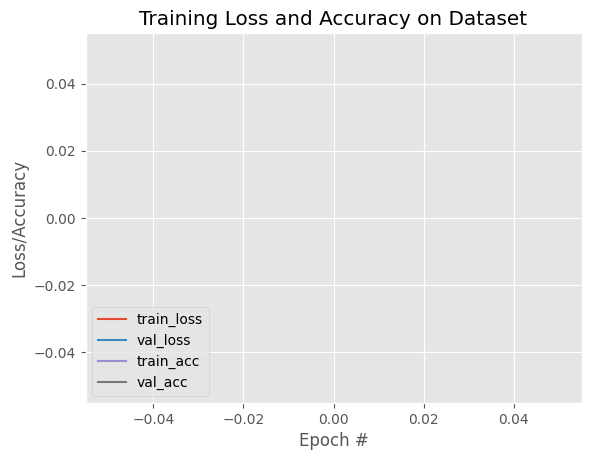

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Part D: Performance Metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

true_labels = []
predicted_labels = []

# Test on validation set
with torch.no_grad():
  net.eval()
  for inputs, labels in val_loader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels)
accuracy = (torch.tensor(predicted_labels) == torch.tensor(true_labels)).sum().item() / len(true_labels)

# Print the results for each class and overall accuracy
for i in range(len(precision)):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1_score[i]:.4f}, Support={support[i]}")
print(f"Overall Accuracy={accuracy:.4f}")

RuntimeError: ignored

ValueError: ignored

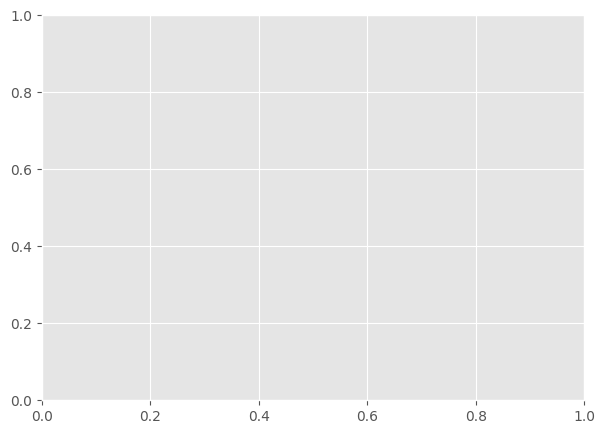

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(true_labels, predicted_labels)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)


The class that was the most difficult for the model to learn is Class 5, HeadCT. in the confusion matrix, this class has the highest value and the lowest precision.